# Procesado del dataset: Getting Real About Fake News
## Fuente: Kaggle. https://www.kaggle.com/mrisdal/fake-news

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import style

#One-hot encodding
from sklearn.preprocessing import LabelBinarizer

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
import swifter

#Nicer style
style.use('seaborn') 

import re #regexp

from nltk.tokenize import RegexpTokenizer

In [2]:
news = pd.read_csv("../data/Other_datasets/GettingRealAboutFake/fake.csv")

Longitudes necesarias de los artículos

In [3]:
#Padding number for title and content
MAX_LEN_TITLE = 13
MAX_LEN_CONTENT = 1598

### Limpieza del dataset.

Nos quedamos con:
 * title
 * language == english
 * text
 * type
 * type != bs $^*$
 
$^*$ *Data sources that were missing a label were simply assigned a label of "bs". There are (ostensibly) no genuine, reliable, or trustworthy news sources represented in this dataset (so far), so don't trust anything you read.*

In [4]:
news = news[news['language'] == 'english']
news = news[news['type'] != 'bs']
news = news[['title', 'text', 'type']]

In [5]:
news.head()

,title,text,type
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,bias
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,bias
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,bias
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,bias
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,bias


El dataset incluye distintos tipos de noticias falsas categorizadas junto a metadatos. Se pretende entrenar un modelo que distinga también verdaderas, por lo que debemos añadir samples verdaderos de FakeNewsCorpus.

Previamente se han extraido sólamente las verdaderas en `data/only_true.csv`.

In [6]:
true_news = pd.read_csv("../data/Other_datasets/GettingRealAboutFake/news_only_true.csv", nrows=1000)

In [7]:
#Poner todos los type como true
true_news['type'] = 'true'

In [8]:
true_news = true_news[['title', 'content', 'type']]
true_news = true_news.rename(str, columns={"content": "text"})

In [9]:
true_news.head()

,title,text,type
0,"Iranian Christian Convert Leads 1,500 Muslims ...",(Screencap: YouTube/Tidningen Dagen) Annahita ...,true
1,Finding wonder and foreboding in the pathway o...,It is rather hard to write with eclipse glasse...,true
2,#MeToo! Our culture of sexual predation – Bapt...,Social media is blowing up about a culture of ...,true
3,God’s invitation to life – Baptist News Global,Many preachers took up the Isaiah 55 passage t...,true
4,What is sown in the heart – Baptist News Global,A trip to the cardiologist is rarely routine. ...,true


Concatenar y shufflear Dataframes

In [10]:
news = pd.concat([news, true_news])
news = news.sample(frac=1).reset_index(drop=True)

Agrupamos los tipos de noticia en bias - fake - true

In [11]:
news.loc[news['type'] =='conspiracy', 'type'] = 'fake'
news.loc[news['type'] =='hate', 'type'] = 'fake'
news.loc[news['type'] =='junksci', 'type'] = 'fake'
news.loc[news['type'] =='satire', 'type'] = 'fake'
news.loc[news['type'] =='state', 'type'] = 'fake'

**Noticias por categoría**

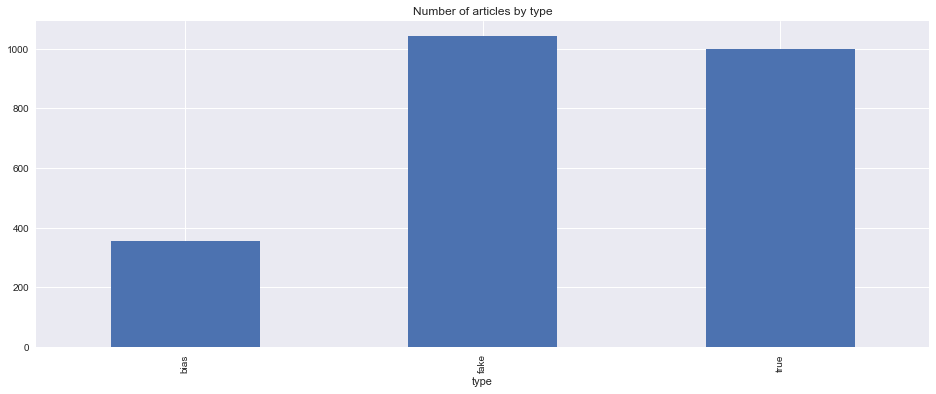

In [12]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['title'].plot.bar(title = "Number of articles by type", ax = ax)

### Vectorización

In [13]:
from gensim.models import KeyedVectors

In [14]:
model = KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin.gz", binary=True,
                                          limit=50000)

In [15]:
news['title'] = news.progress_apply(lambda r: 
                        [model.vocab[x].index for x in str(r['title']) if x in model.vocab], axis=1)

100%|██████████| 2503/2503 [00:00<00:00, 17425.65it/s]


In [16]:
news['content'] = news.progress_apply(lambda r: 
                        [model.vocab[x].index for x in str(r['text']) if x in model.vocab], axis=1)

100%|██████████| 2503/2503 [00:01<00:00, 2373.28it/s]


In [17]:
news = news.drop('text', axis=1)
news.head()

,title,type,content
0,"[4024, 2370, 1280, 11538, 17251, 20, 17919, 57...",fake,"[4024, 2370, 1280, 11538, 17251, 20, 17919, 57..."
1,"[5977, 4211, 7726, 11538, 9311, 8469, 4211, 12...",fake,"[5760, 5760]"
2,"[7203, 15775, 15775, 3581, 7726, 17919, 4211, ...",fake,"[3708, 4211, 5760, 7726, 15775, 4211, 6869, 42..."
3,"[11969, 4211, 1280, 4883, 4501, 23199, 8469, 2...",fake,"[3708, 11538, 7726, 11538, 73, 17919, 7726, 45..."
4,"[3581, 4501, 11538, 16205, 8303, 20, 5760, 846...",fake,"[3581, 4501, 11538, 16205, 8303, 20, 5760, 846..."


In [18]:
news = news[news['title'].map(len) >= 1]
#Reset index
news = news.reset_index().drop("index", axis=1)

In [19]:
def pad_array(array, token_len):
    diff_token = token_len - len(array)
    if(diff_token < 0):
        array = array[:token_len] #Truncate
    else:
        #Pad
        array += [0]*diff_token #Pad
        
    return array  

Pandas Apply: 100%|██████████| 2503/2503 [00:00<00:00, 45125.24it/s]


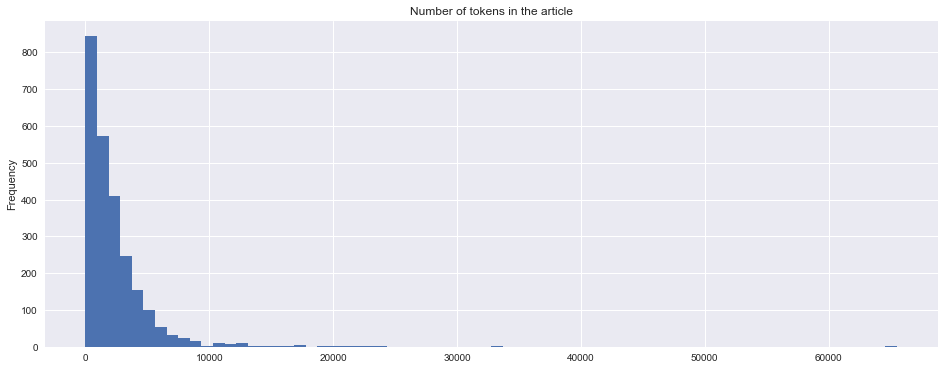

In [20]:
# Longitud en tokens de cada noticia
tokens_numbers = news.swifter.apply(lambda row: len(row['content']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 70, ax=ax)

In [21]:
print("Número medio de tokens por artículo: {}".format(int(np.mean(tokens_numbers))))
print("Desviación estándar de tokens por artículo: {}".format(int(np.std(tokens_numbers))))
print("Mediana de tokens por artículo: {}".format(int(np.median(tokens_numbers))))

max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Ventana de tokens escogida: {} - Cubre el {}% del dataset".format(max_tokens, percent_tokens*100))

Número medio de tokens por artículo: 2260
Desviación estándar de tokens por artículo: 2892
Mediana de tokens por artículo: 1592
Ventana de tokens escogida: 8045 - Cubre el 96.92369157011586% del dataset


In [22]:
n_tokens = max_tokens
news['content'] = news.apply(lambda r: pad_array(r['content'], MAX_LEN_CONTENT) , axis=1) #Use necessary for the model

Pandas Apply:   0%|          | 0/2503 [00:00<?, ?it/s]

Número medio de tokens por título: 47
Desviación estándar de tokens por título: 22
Mediana de tokens por título: 47
Ventana de tokens escogida: 93 - Cubre el 96.763883339992% del dataset


Pandas Apply: 100%|██████████| 2503/2503 [00:00<00:00, 35954.46it/s]


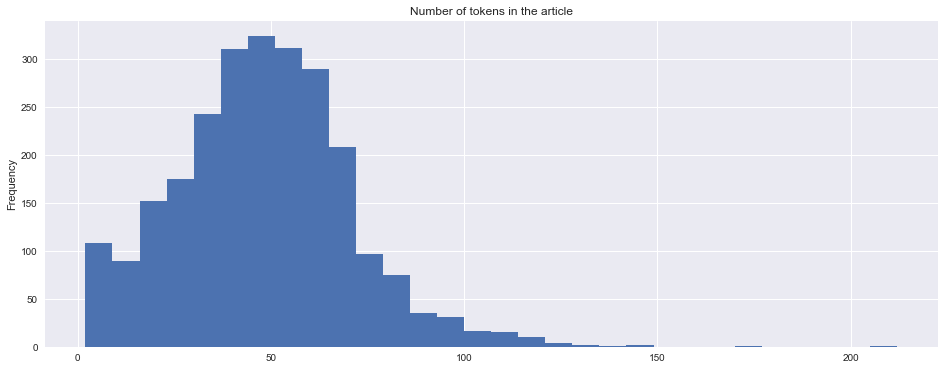

In [23]:
# Longitud en tokens de cada noticia
tokens_numbers = news.apply(lambda row: len(row['title']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 30, ax=ax)

print("Número medio de tokens por título: {}".format(int(np.mean(tokens_numbers))))
print("Desviación estándar de tokens por título: {}".format(int(np.std(tokens_numbers))))
print("Mediana de tokens por título: {}".format(int(np.median(tokens_numbers))))

max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

n_tokens = max_tokens

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Ventana de tokens escogida: {} - Cubre el {}% del dataset".format(max_tokens, percent_tokens*100))

#Use necessary for the model
news['title'] = news.progress_apply(lambda r: pad_array(r['title'], MAX_LEN_TITLE) , axis=1)

### Label a categorical

In [24]:
encoder = LabelBinarizer().fit(list(news['type']))
news['one_hot_label'] = news.apply(lambda r: encoder.transform([r['type']])[0], axis=1)
news.head()

,title,type,content,one_hot_label
0,"[4024, 2370, 1280, 11538, 17251, 20, 17919, 57...",fake,"[4024, 2370, 1280, 11538, 17251, 20, 17919, 57...","[0, 1, 0]"
1,"[5977, 4211, 7726, 11538, 9311, 8469, 4211, 12...",fake,"[5760, 5760, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0]"
2,"[7203, 15775, 15775, 3581, 7726, 17919, 4211, ...",fake,"[3708, 4211, 5760, 7726, 15775, 4211, 6869, 42...","[0, 1, 0]"
3,"[11969, 4211, 1280, 4883, 4501, 23199, 8469, 2...",fake,"[3708, 11538, 7726, 11538, 73, 17919, 7726, 45...","[0, 1, 0]"
4,"[3581, 4501, 11538, 16205, 8303, 20, 5760, 846...",fake,"[3581, 4501, 11538, 16205, 8303, 20, 5760, 846...","[0, 1, 0]"


In [25]:
print("LABELS")
enc = encoder.transform(encoder.classes_)
for x, y in zip(encoder.classes_, enc):
    print(x, y)

LABELS
bias [1 0 0]
fake [0 1 0]
true [0 0 1]


In [26]:
### Guardar el dataset
news.to_pickle('../data/news_getting_real.pickle')